In [192]:
import warnings 
warnings.filterwarnings('ignore')

In [52]:
import numpy as np
import pandas as pd
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

### Generate Data

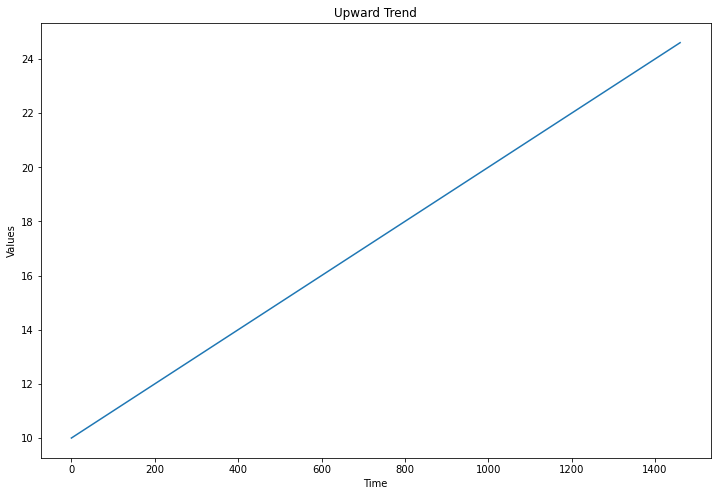

In [53]:
# Trend Part
time = np.arange(4*365 + 1)
trend = 10 + 0.01 * time

plt.figure(figsize=(12,8))
plt.plot(time, trend);
plt.title("Upward Trend")
plt.xlabel('Time');
plt.ylabel('Values');

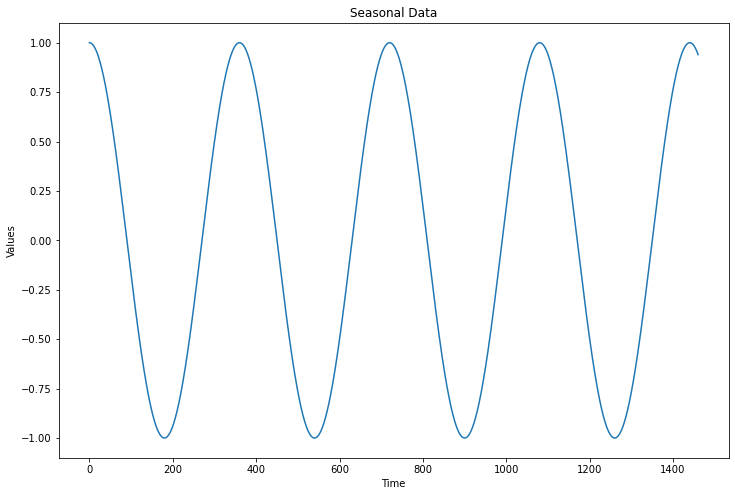

In [54]:
#seasonality 
season = np.cos(time * np.pi * 2 / 360)


plt.figure(figsize=(12,8));
plt.plot(time, season);
plt.title('Seasonal Data')
plt.xlabel('Time');
plt.ylabel('Values');

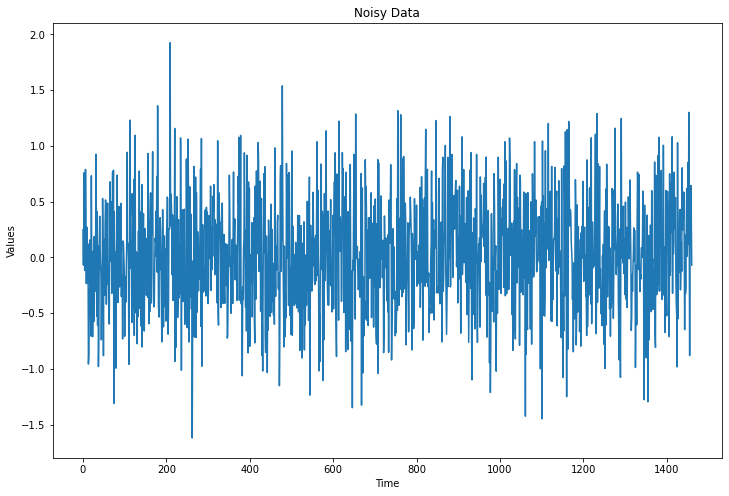

In [55]:
# Noise
noise = np.random.normal(loc=0.0, scale=0.5, size=time.shape)

plt.figure(figsize=(12,8));
plt.plot(time, noise);
plt.title('Noisy Data')
plt.xlabel('Time');
plt.ylabel('Values');

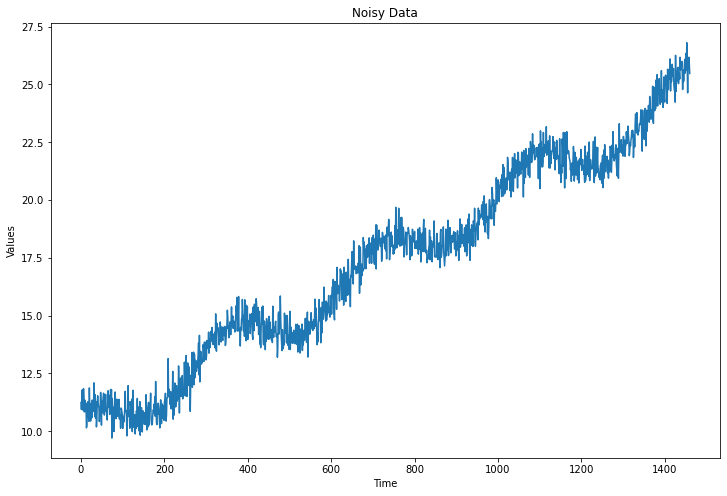

In [56]:
# All Combined
series = trend + season + noise

plt.figure(figsize=(12,8));
plt.plot(time, series);
plt.title('Noisy Data')
plt.xlabel('Time');
plt.ylabel('Values');

## Naive Forecast

In [57]:
# Next day will have the same value as today
SPLIT_TIME = int(np.floor(2.5*365))

train_time = time[:SPLIT_TIME]
valid_time = time[SPLIT_TIME:]

train_set = series[:SPLIT_TIME]
valid_set = series[SPLIT_TIME:]

In [58]:
#Naive Forecast
naive = valid_set[:-1]

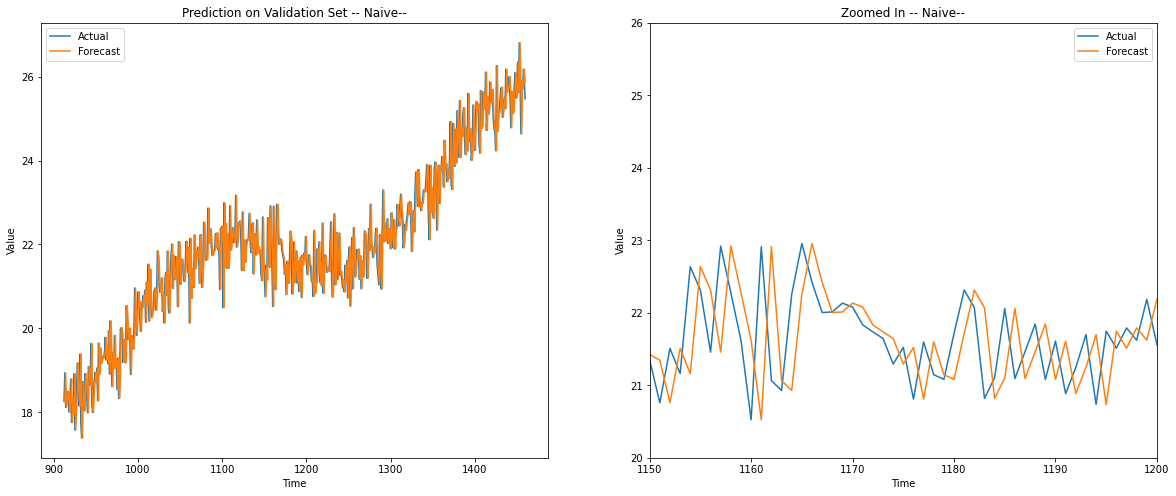

In [59]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Naive--')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(valid_time[1:], naive, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Naive--')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(valid_time[1:], naive, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1200, 20, 26])
plt.legend();

In [60]:
# Measuring Preformance
import keras
from keras.losses import mean_squared_error

naive_mse = mean_squared_error(naive, valid_set[1:])
print(f'Mean Squared Error of Naive Classifier {naive_mse}')

Mean Squared Error of Naive Classifier 0.5178001523017883


## Moving Average

In [61]:
# Next day will be average of 10 last days
moving_average = np.array(pd.Series(valid_set).rolling(10).mean())

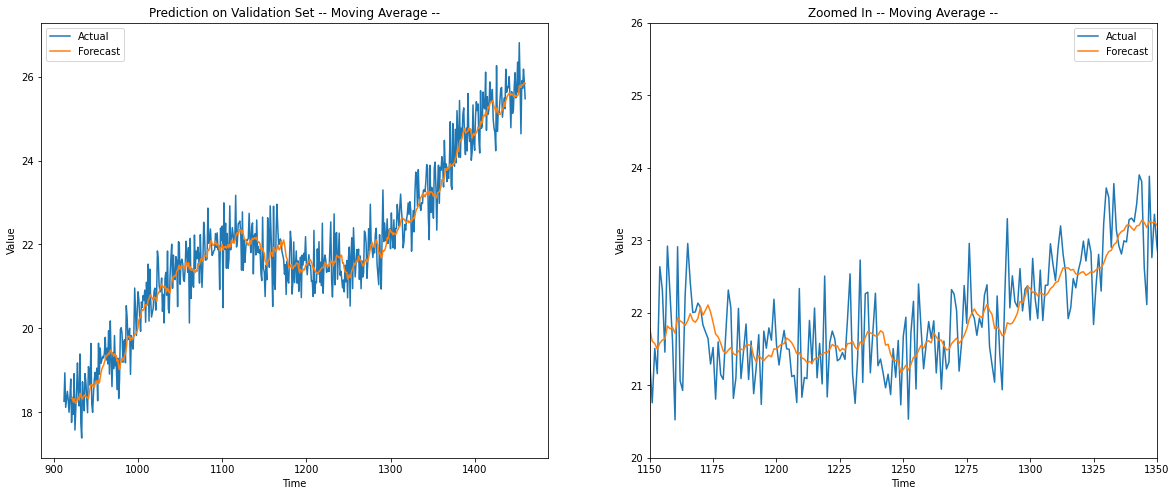

In [62]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Moving Average --')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(valid_time, moving_average, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Moving Average --')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(valid_time, moving_average, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();


In [63]:
# Measuring Preformance
moving_mse = mean_squared_error(moving_average[9:-1], valid_set[10:])
print(f'Mean Squared Error of Moving Average Classifier {moving_mse}')

Mean Squared Error of Moving Average Classifier 0.28498440980911255


## Removing Seasonality and Trend

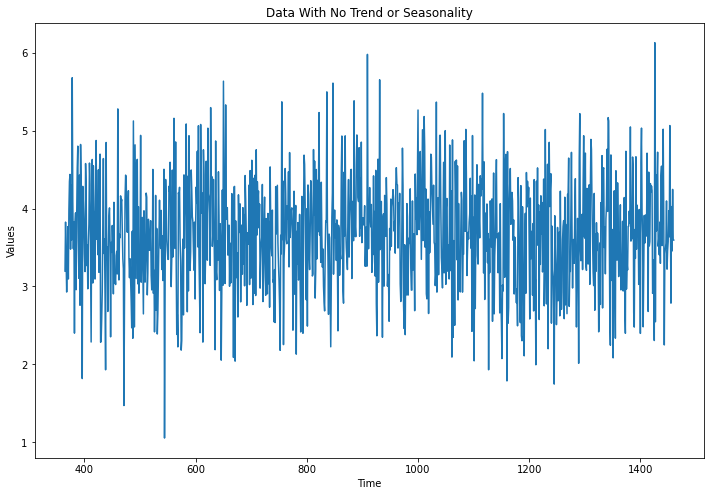

In [64]:
# Just Noise
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(12,8));
plt.plot(diff_time, diff_series);
plt.title('Data With No Trend or Seasonality')
plt.xlabel('Time');
plt.ylabel('Values');

In [65]:
diff_moving_average = np.array(pd.Series(diff_series).rolling(10).mean())

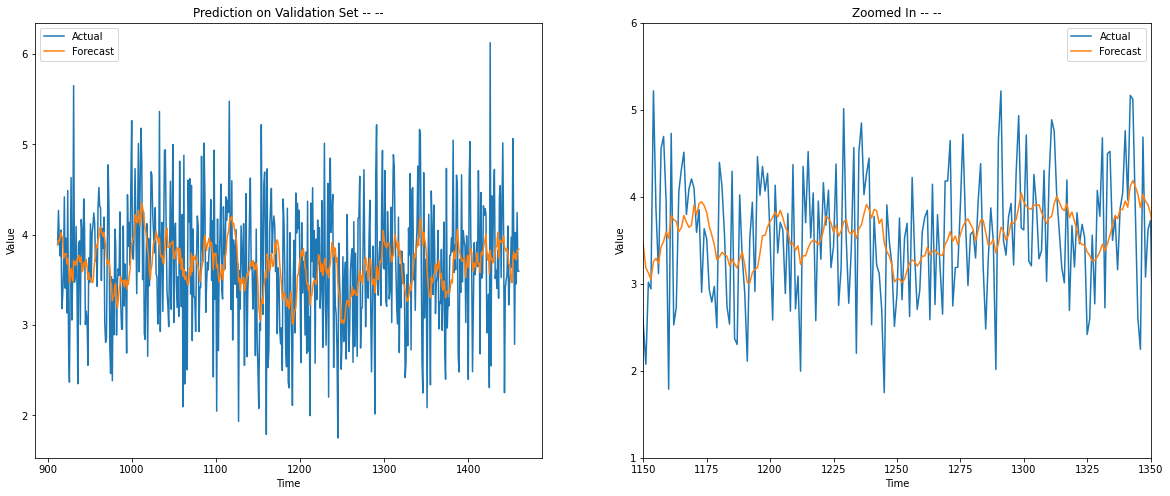

In [66]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- --')
plt.plot(diff_time[SPLIT_TIME-365:], diff_series[SPLIT_TIME-365:], label='Actual');
plt.plot(diff_time[SPLIT_TIME-365:], diff_moving_average[SPLIT_TIME-365:], label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- --')
plt.plot(diff_time, diff_series, label='Actual');
plt.plot(diff_time, diff_moving_average, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 1, 6])
plt.legend();

In [67]:
# Adding back trend and seasonality

full_series = diff_moving_average + series[:-365]
valid_set_ma = full_series[SPLIT_TIME-365:]
time_ma = time[SPLIT_TIME:]

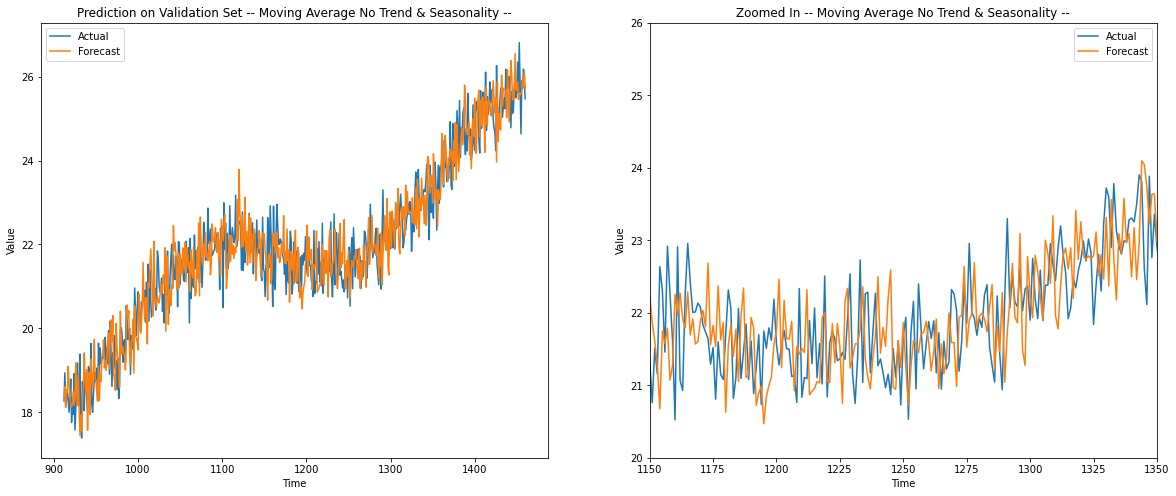

In [68]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Moving Average No Trend & Seasonality --')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(time_ma, valid_set_ma, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Moving Average No Trend & Seasonality --')
plt.plot(valid_time, valid_set, label='Actual');
plt.plot(time_ma, valid_set_ma, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

In [69]:
# Measuring Preformance
moving_no_trend_mse = mean_squared_error(valid_set_ma, valid_set)
print(f'Mean Squared Error of MA Classifier {moving_no_trend_mse}')

Mean Squared Error of MA Classifier 0.4516891837120056


## Modeling

In [70]:
#prepare X,y Pairs TrainSet
def prepareSeq(dataset, WINDOW_SIZE):
    X=[]
    y=[]
    
    for index in range(WINDOW_SIZE, len(dataset)):
        X.append(dataset[index-WINDOW_SIZE:index])
        y.append(dataset[index])
        
    X = np.array(X)
    y = np.array(y).reshape(-1,1)
                 
    return X,y   

In [71]:
WINDOW_SIZE = 30
train_X, train_y = prepareSeq(train_set, WINDOW_SIZE)
valid_X, valid_y = prepareSeq(valid_set, WINDOW_SIZE)

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_X)
y_scaler.fit(train_y)

scaled_X_train = x_scaler.transform(train_X)
scaled_y_train = y_scaler.transform(train_y)

scaled_X_valid = x_scaler.transform(valid_X)
scaled_y_valid = y_scaler.transform(valid_y)

### Random Forest Model

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as sk_mse

rf = RandomForestRegressor()
rf.fit(train_X, train_y)
rf_pred = rf.predict(valid_X)
rf_mse = sk_mse(valid_y, rf_pred)
print(f'Mean Squared Error of Random Forrest: {rf_mse}')

Mean Squared Error of Random Forrest: 14.424764672568928


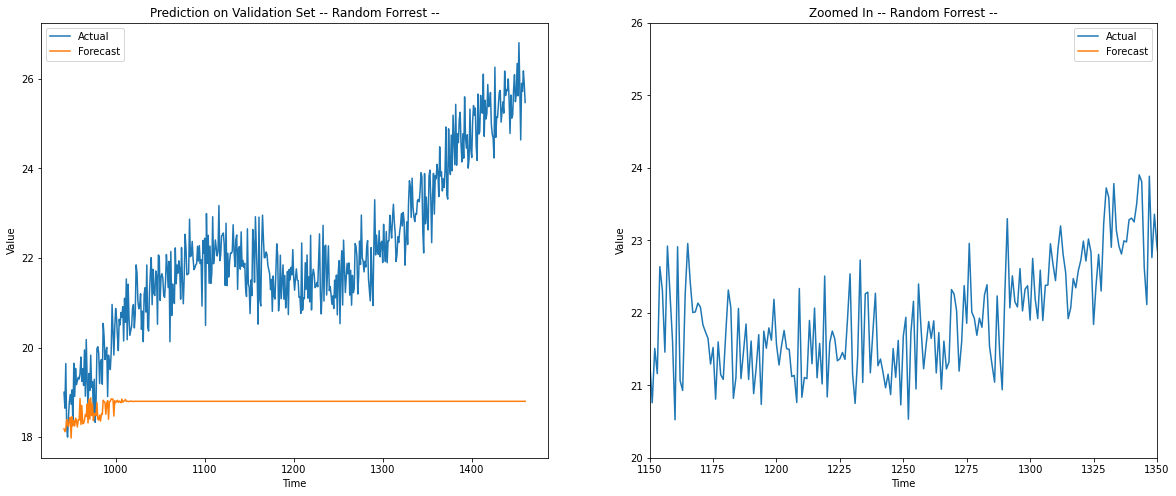

In [74]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Random Forrest --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], rf_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Random Forrest --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], rf_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as sk_mse

lr = LinearRegression()
lr.fit(train_X, train_y)
lr_pred = lr.predict(valid_X)
lr_mse = sk_mse(valid_y, lr_pred)
print(f'Mean Squared Error of Linear Regression: {lr_mse}')

Mean Squared Error of Linear Regression: 0.2876352368585512


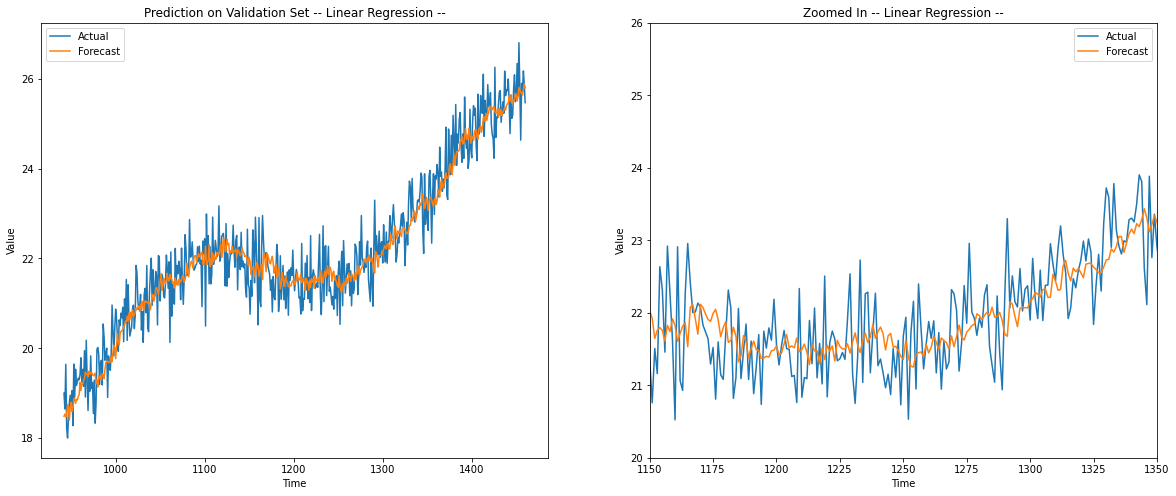

In [76]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Linear Regression --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Linear Regression --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### Simple Regression Model

In [77]:
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.optimizers import Adam

regressor = Sequential(
    [
        Dense(1, input_shape=[scaled_X_train.shape[1]])
    ]
)

regressor.compile(optimizer=Adam(0.01), loss=mean_squared_error)
history = regressor.fit(scaled_X_train, scaled_y_train,
                        validation_data=(scaled_X_valid, scaled_y_valid),
                        batch_size=16, epochs=100)

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 0s 288us/step - loss: 0.3895 - val_loss: 0.0122
Epoch 2/100
882/882 [==============================] - 0s 58us/step - loss: 0.0092 - val_loss: 0.0118
Epoch 3/100
882/882 [==============================] - ETA: 0s - loss: 0.003 - 0s 55us/step - loss: 0.0077 - val_loss: 0.0088
Epoch 4/100
882/882 [==============================] - 0s 51us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 5/100
882/882 [==============================] - 0s 55us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/100
882/882 [==============================] - 0s 62us/step - loss: 0.0068 - val_loss: 0.0085
Epoch 7/100
882/882 [==============================] - 0s 56us/step - loss: 0.0067 - val_loss: 0.0072
Epoch 8/100
882/882 [==============================] - 0s 56us/step - loss: 0.0067 - val_loss: 0.0104
Epoch 9/100
882/882 [==============================] - 0s 54us/step - loss: 0.0066 - val_loss: 0.0074
Epoch 10/10

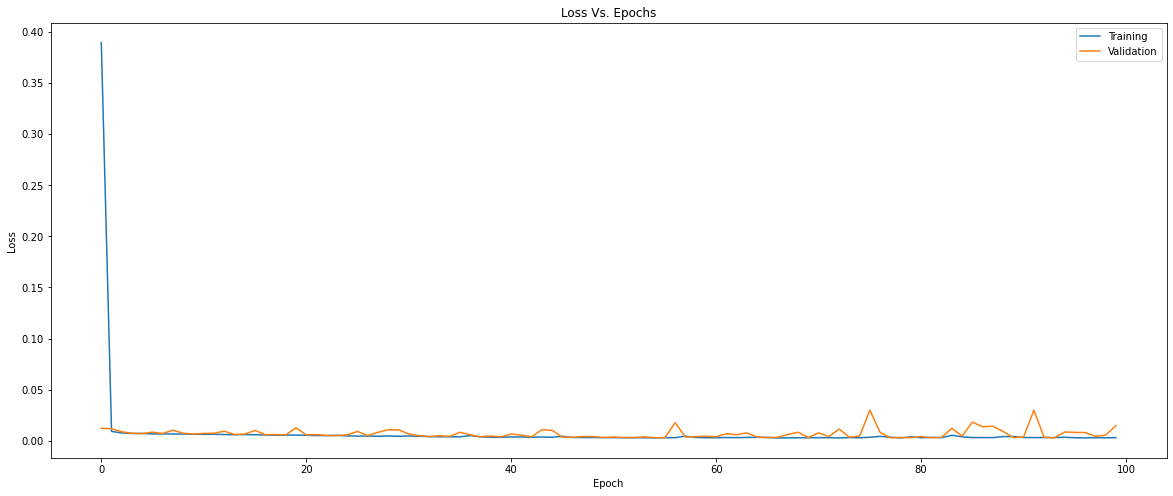

In [78]:
plt.figure(figsize=(20,8));

plt.plot(range(100), history.history['loss'], label='Training');
plt.plot(range(100), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [79]:
reg_pred = y_scaler.inverse_transform(regressor.predict(scaled_X_valid))

reg_mse = sk_mse(reg_pred, valid_y)
print(f'Mean Squared Error of Simple Regressor: {reg_mse}')

Mean Squared Error of Simple Regressor: 1.484114438740744


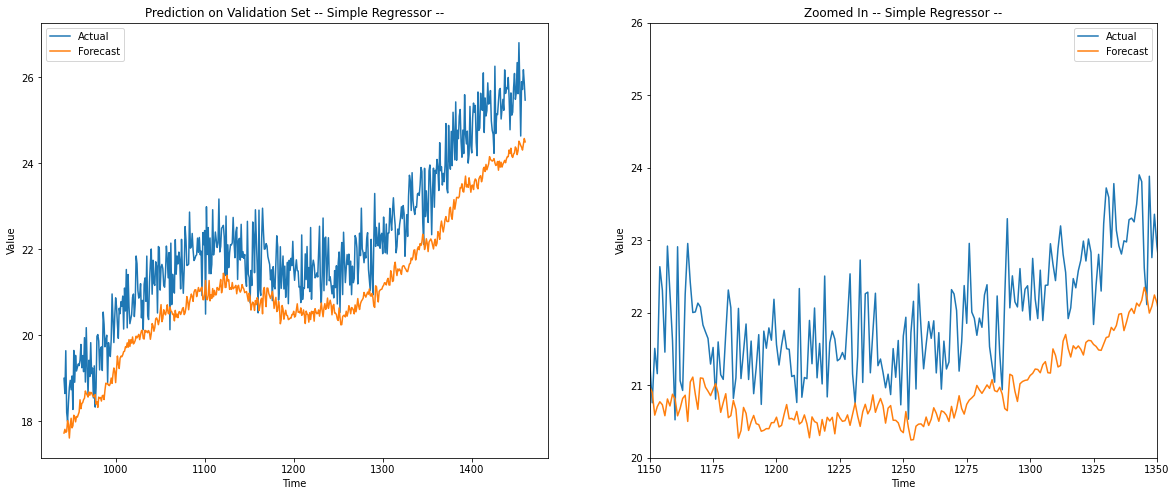

In [80]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Simple Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], reg_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Simple Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], reg_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### Simple Regreesor with Callbacks

In [81]:
#Determine best Learning Rate
from keras.callbacks import LearningRateScheduler

regressor_pick_lr = Sequential(
    [
        Dense(1, input_shape=[scaled_X_train.shape[1]])
    ]
)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 30))

regressor_pick_lr.compile(optimizer=Adam(0.01), loss=mean_squared_error)

history = regressor_pick_lr.fit(scaled_X_train, scaled_y_train,
                                validation_data=(scaled_X_valid, scaled_y_valid),
                                batch_size=16, epochs=100,
                                callbacks=[lr_schedule])

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 0s 100us/step - loss: 2.6364 - val_loss: 13.1508
Epoch 2/100
882/882 [==============================] - 0s 55us/step - loss: 2.6332 - val_loss: 13.1346
Epoch 3/100
882/882 [==============================] - 0s 55us/step - loss: 2.6297 - val_loss: 13.1167
Epoch 4/100
882/882 [==============================] - 0s 61us/step - loss: 2.6259 - val_loss: 13.0976
Epoch 5/100
882/882 [==============================] - 0s 52us/step - loss: 2.6219 - val_loss: 13.0774
Epoch 6/100
882/882 [==============================] - 0s 49us/step - loss: 2.6176 - val_loss: 13.0554
Epoch 7/100
882/882 [==============================] - 0s 57us/step - loss: 2.6129 - val_loss: 13.0318
Epoch 8/100
882/882 [==============================] - 0s 55us/step - loss: 2.6079 - val_loss: 13.0065
Epoch 9/100
882/882 [==============================] - 0s 57us/step - loss: 2.6024 - val_loss: 12.9786
Epoch 10/100
882/882 [====

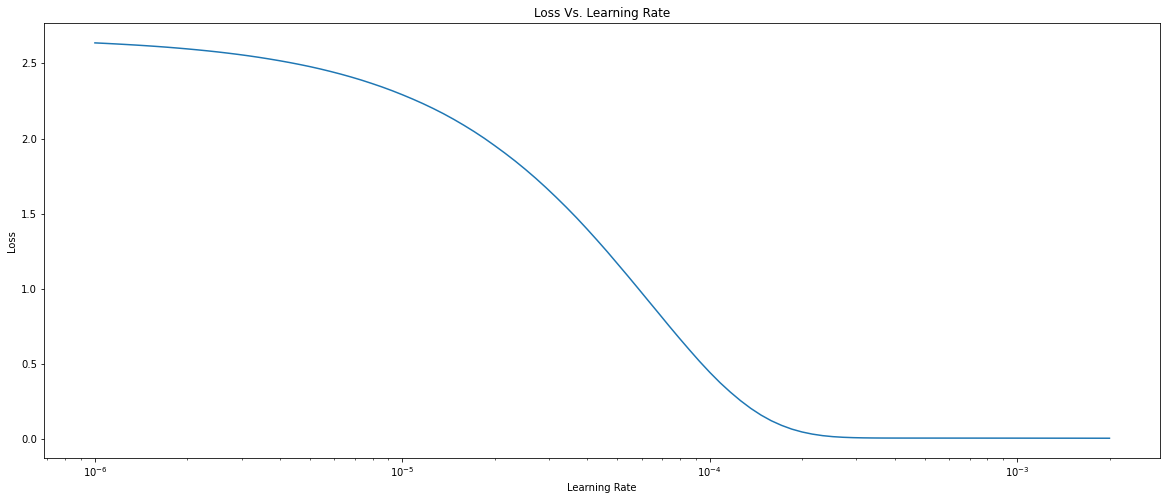

In [82]:
plt.figure(figsize=(20,8));

plt.title('Loss Vs. Learning Rate')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate');
plt.ylabel('Loss');

#### 1e-3 seems good

In [83]:
#Earlt Stopping
from keras.callbacks import EarlyStopping

regressor_best_lr = Sequential(
    [
        Dense(1, input_shape=[scaled_X_train.shape[1]])
    ]
)

earlyStopping = EarlyStopping(patience=10)

regressor_best_lr.compile(optimizer=Adam(1e-3), loss=mean_squared_error)

history = regressor_best_lr.fit(scaled_X_train, scaled_y_train,
                                validation_data=(scaled_X_valid, scaled_y_valid),
                                batch_size=16, epochs=500,
                                callbacks=[earlyStopping])

Train on 882 samples, validate on 519 samples
Epoch 1/500
882/882 [==============================] - 0s 123us/step - loss: 0.2484 - val_loss: 0.0767
Epoch 2/500
882/882 [==============================] - 0s 71us/step - loss: 0.0083 - val_loss: 0.0077
Epoch 3/500
882/882 [==============================] - 0s 67us/step - loss: 0.0070 - val_loss: 0.0083
Epoch 4/500
882/882 [==============================] - 0s 66us/step - loss: 0.0070 - val_loss: 0.0082
Epoch 5/500
882/882 [==============================] - 0s 67us/step - loss: 0.0069 - val_loss: 0.0081
Epoch 6/500
882/882 [==============================] - 0s 63us/step - loss: 0.0069 - val_loss: 0.0087
Epoch 7/500
882/882 [==============================] - 0s 60us/step - loss: 0.0069 - val_loss: 0.0087
Epoch 8/500
882/882 [==============================] - 0s 62us/step - loss: 0.0069 - val_loss: 0.0085
Epoch 9/500
882/882 [==============================] - 0s 71us/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/500
882/882 [=============

882/882 [==============================] - 0s 51us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 160/500
882/882 [==============================] - 0s 53us/step - loss: 0.0029 - val_loss: 0.0039
Epoch 161/500
882/882 [==============================] - 0s 51us/step - loss: 0.0029 - val_loss: 0.0032
Epoch 162/500
882/882 [==============================] - 0s 53us/step - loss: 0.0029 - val_loss: 0.0042


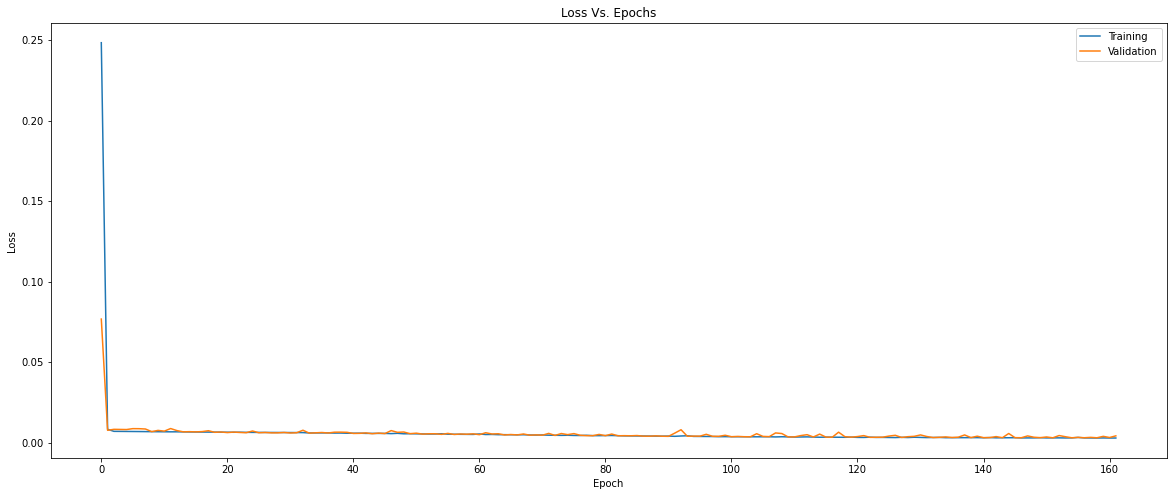

In [85]:
plt.figure(figsize=(20,8));

plt.plot(range(162), history.history['loss'], label='Training');
plt.plot(range(162), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [86]:
reg_lr_pred = y_scaler.inverse_transform(regressor_best_lr.predict(scaled_X_valid))

reg_lr_mse = sk_mse(reg_lr_pred, valid_y)
print(f'Mean Squared Error of Simple Regressor: {reg_lr_mse}')

Mean Squared Error of Simple Regressor: 0.41948560877258545


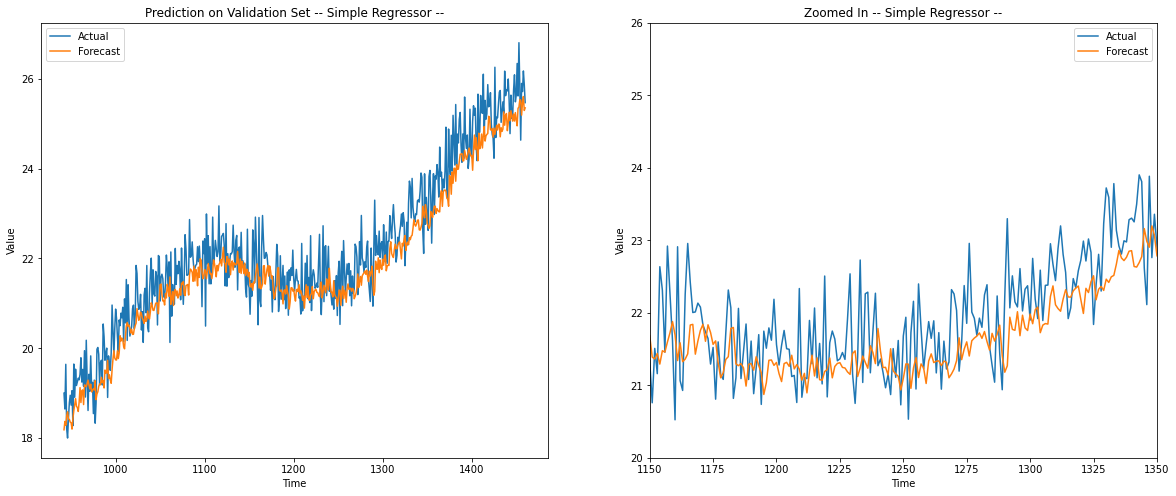

In [87]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Simple Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], reg_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Simple Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], reg_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### Densed Regressor

In [88]:
densed_regressor_pick_lr = Sequential(
    [
        Dense(10, input_shape=[scaled_X_train.shape[1]]),
        Dense(10),
        Dense(1)
    ]
)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 30))

densed_regressor_pick_lr.compile(optimizer=Adam(0.01), loss=mean_squared_error)

history = densed_regressor_pick_lr.fit(scaled_X_train, scaled_y_train,
                                       validation_data=(scaled_X_valid, scaled_y_valid),
                                       batch_size=16, epochs=100,
                                       callbacks=[lr_schedule])

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 0s 213us/step - loss: 0.4211 - val_loss: 2.0543
Epoch 2/100
882/882 [==============================] - 0s 77us/step - loss: 0.4146 - val_loss: 2.0223
Epoch 3/100
882/882 [==============================] - 0s 71us/step - loss: 0.4076 - val_loss: 1.9877
Epoch 4/100
882/882 [==============================] - 0s 63us/step - loss: 0.4003 - val_loss: 1.9513
Epoch 5/100
882/882 [==============================] - 0s 73us/step - loss: 0.3923 - val_loss: 1.9124
Epoch 6/100
882/882 [==============================] - 0s 71us/step - loss: 0.3839 - val_loss: 1.8708
Epoch 7/100
882/882 [==============================] - 0s 65us/step - loss: 0.3751 - val_loss: 1.8265
Epoch 8/100
882/882 [==============================] - 0s 64us/step - loss: 0.3657 - val_loss: 1.7803
Epoch 9/100
882/882 [==============================] - 0s 70us/step - loss: 0.3558 - val_loss: 1.7316
Epoch 10/100
882/882 [=============

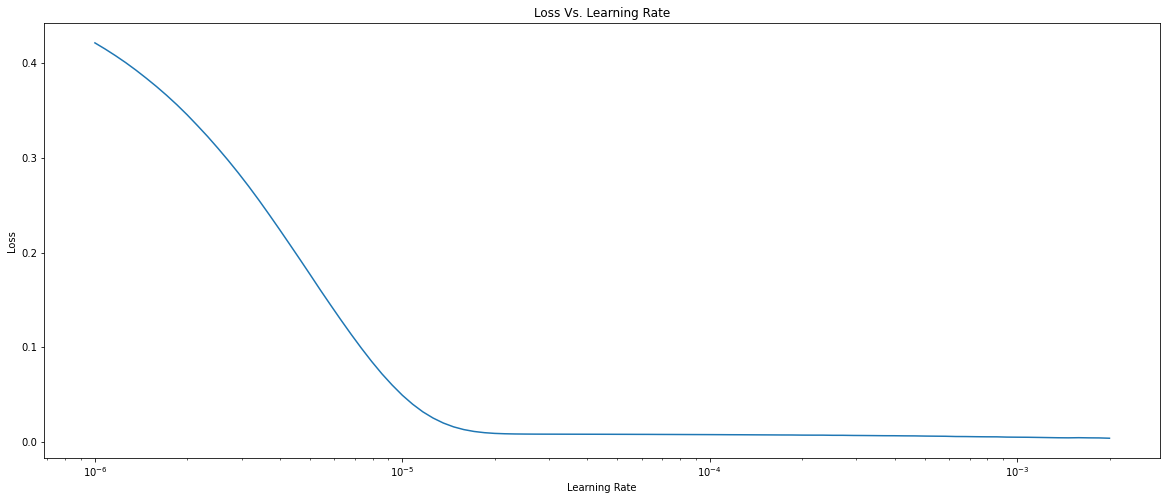

In [89]:
plt.figure(figsize=(20,8));

plt.title('Loss Vs. Learning Rate')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate');
plt.ylabel('Loss');

In [90]:
densed_regressor_best_lr = Sequential(
    [
        Dense(10, input_shape=[scaled_X_train.shape[1]]),
        Dense(10),
        Dense(1)    ]
)

earlyStopping = EarlyStopping(patience=10)

densed_regressor_best_lr.compile(optimizer=Adam(1e-3), loss=mean_squared_error)

history = densed_regressor_best_lr.fit(scaled_X_train, scaled_y_train,
                                       validation_data=(scaled_X_valid, scaled_y_valid),
                                       batch_size=16, epochs=500,
                                       callbacks=[earlyStopping])

Train on 882 samples, validate on 519 samples
Epoch 1/500
882/882 [==============================] - 0s 143us/step - loss: 0.0181 - val_loss: 0.0123
Epoch 2/500
882/882 [==============================] - 0s 67us/step - loss: 0.0075 - val_loss: 0.0079
Epoch 3/500
882/882 [==============================] - 0s 65us/step - loss: 0.0070 - val_loss: 0.0124
Epoch 4/500
882/882 [==============================] - 0s 66us/step - loss: 0.0064 - val_loss: 0.0099
Epoch 5/500
882/882 [==============================] - 0s 77us/step - loss: 0.0059 - val_loss: 0.0060
Epoch 6/500
882/882 [==============================] - 0s 119us/step - loss: 0.0052 - val_loss: 0.0056
Epoch 7/500
882/882 [==============================] - 0s 72us/step - loss: 0.0050 - val_loss: 0.0056
Epoch 8/500
882/882 [==============================] - 0s 69us/step - loss: 0.0046 - val_loss: 0.0055
Epoch 9/500
882/882 [==============================] - 0s 64us/step - loss: 0.0043 - val_loss: 0.0059
Epoch 10/500
882/882 [============

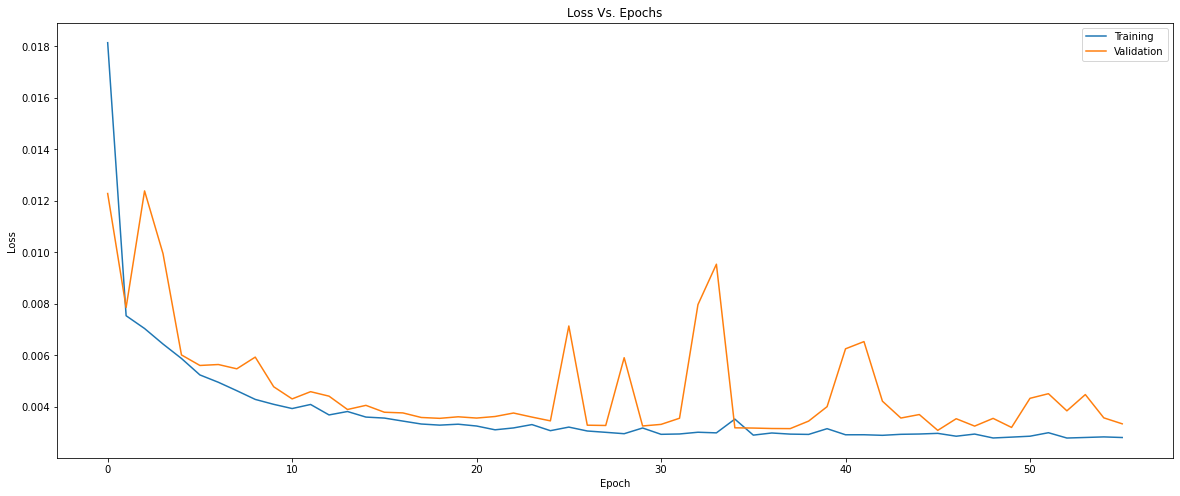

In [91]:
plt.figure(figsize=(20,8));

plt.plot(range(56), history.history['loss'], label='Training');
plt.plot(range(56), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [92]:
dense_reg_lr_pred = y_scaler.inverse_transform(densed_regressor_best_lr.predict(scaled_X_valid))

dense_reg_lr_mse = sk_mse(dense_reg_lr_pred, valid_y)
print(f'Mean Squared Error of Simple Regressor: {dense_reg_lr_mse}')

Mean Squared Error of Simple Regressor: 0.3322266956838384


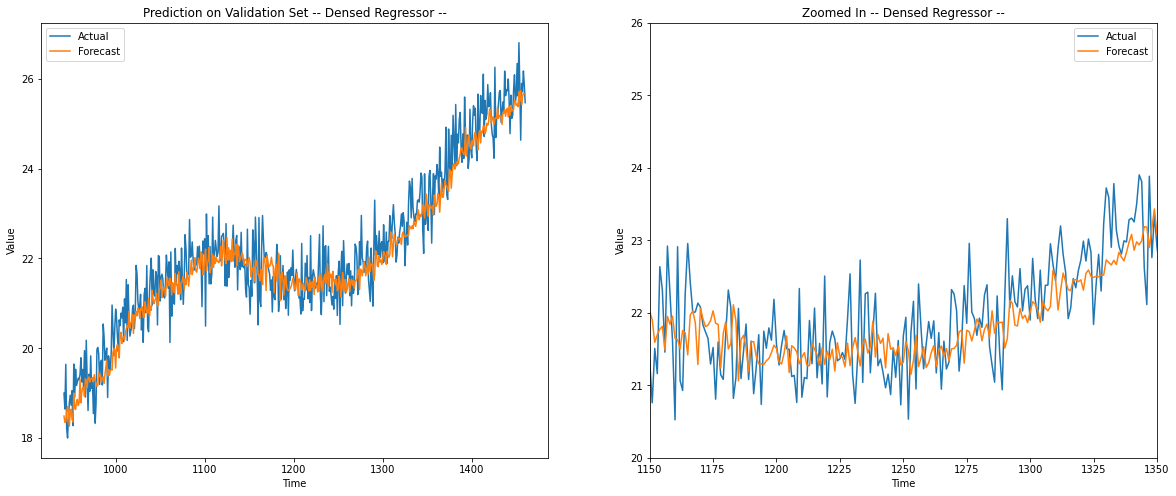

In [93]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Densed Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], dense_reg_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Densed Regressor --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], dense_reg_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### LSTM

In [108]:
lstm_X_train = np.array([sample.reshape(-1,1) for sample in scaled_X_train])
lstm_X_valid = np.array([sample.reshape(-1,1) for sample in scaled_X_valid])

In [110]:
from keras.layers import LSTM, Lambda
from tensorflow import expand_dims

lstm_pick_lr = Sequential(
    [
        LSTM(30, return_sequences = True, input_shape=(WINDOW_SIZE,1)),
        LSTM(30),
        Dense(1)
    ]
)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 30))

lstm_pick_lr.compile(optimizer=Adam(0.01), loss=mean_squared_error)

history = lstm_pick_lr.fit(lstm_X_train, scaled_y_train,
                           validation_data=(lstm_X_valid, scaled_y_valid),
                           batch_size=16, epochs=100,
                           callbacks=[lr_schedule])

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 2s 2ms/step - loss: 0.3778 - val_loss: 1.8812
Epoch 2/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3750 - val_loss: 1.8691
Epoch 3/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3721 - val_loss: 1.8559
Epoch 4/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3690 - val_loss: 1.8420
Epoch 5/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3657 - val_loss: 1.8270
Epoch 6/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3621 - val_loss: 1.8113
Epoch 7/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3583 - val_loss: 1.7940
Epoch 8/100
882/882 [==============================] - ETA: 0s - loss: 0.354 - 1s 1ms/step - loss: 0.3543 - val_loss: 1.7759
Epoch 9/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3499 - val_loss: 1.7560
Epoch 10/100
882/882 

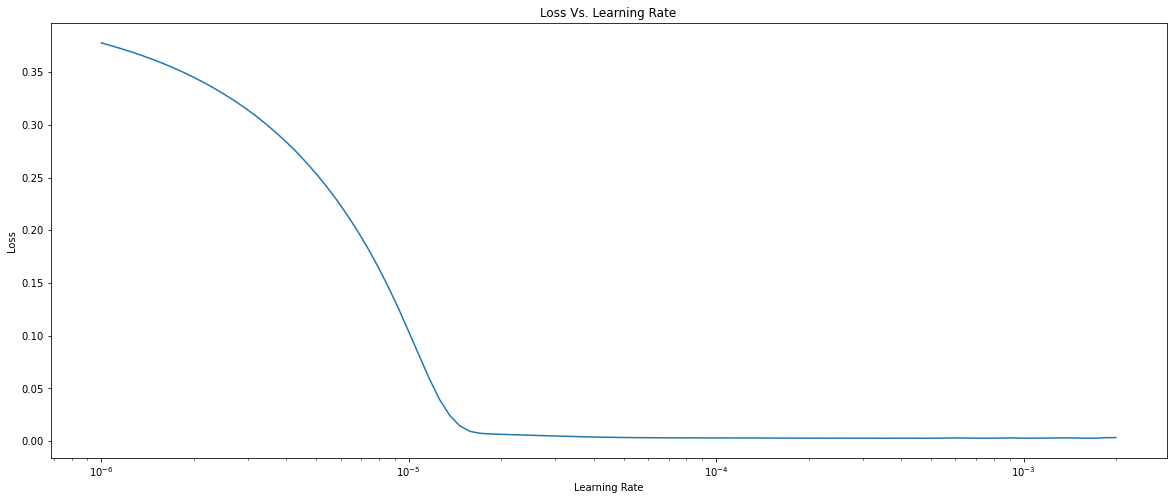

In [111]:
plt.figure(figsize=(20,8));

plt.title('Loss Vs. Learning Rate')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate');
plt.ylabel('Loss');

In [123]:
lstm_best_lr = Sequential(
    [
        LSTM(30, return_sequences = True, input_shape=(WINDOW_SIZE,1)),
        LSTM(30),
        Dense(1)
    ]
)

earlyStopping = EarlyStopping(patience=50)

lstm_best_lr.compile(optimizer=Adam(1e-5), loss=mean_squared_error)

history = lstm_best_lr.fit(lstm_X_train, scaled_y_train,
                           validation_data=(lstm_X_valid, scaled_y_valid),
                           batch_size=16, epochs=500,
                           callbacks=[earlyStopping])

Train on 882 samples, validate on 519 samples
Epoch 1/500
882/882 [==============================] - 2s 2ms/step - loss: 0.4036 - val_loss: 1.9054
Epoch 2/500
882/882 [==============================] - ETA: 0s - loss: 0.3731- ETA: 0s -  - 1s 1ms/step - loss: 0.3750 - val_loss: 1.7882
Epoch 3/500
882/882 [==============================] - 1s 1ms/step - loss: 0.3473 - val_loss: 1.6719
Epoch 4/500
882/882 [==============================] - 1s 1ms/step - loss: 0.3204 - val_loss: 1.5561
Epoch 5/500
882/882 [==============================] - 1s 1ms/step - loss: 0.2939 - val_loss: 1.4396
Epoch 6/500
882/882 [==============================] - 1s 1ms/step - loss: 0.2668 - val_loss: 1.3184
Epoch 7/500
882/882 [==============================] - 1s 1ms/step - loss: 0.2391 - val_loss: 1.1937
Epoch 8/500
882/882 [==============================] - 1s 1ms/step - loss: 0.2107 - val_loss: 1.0633
Epoch 9/500
882/882 [==============================] - 1s 2ms/step - loss: 0.1815 - val_loss: 0.9293
Epoch 10

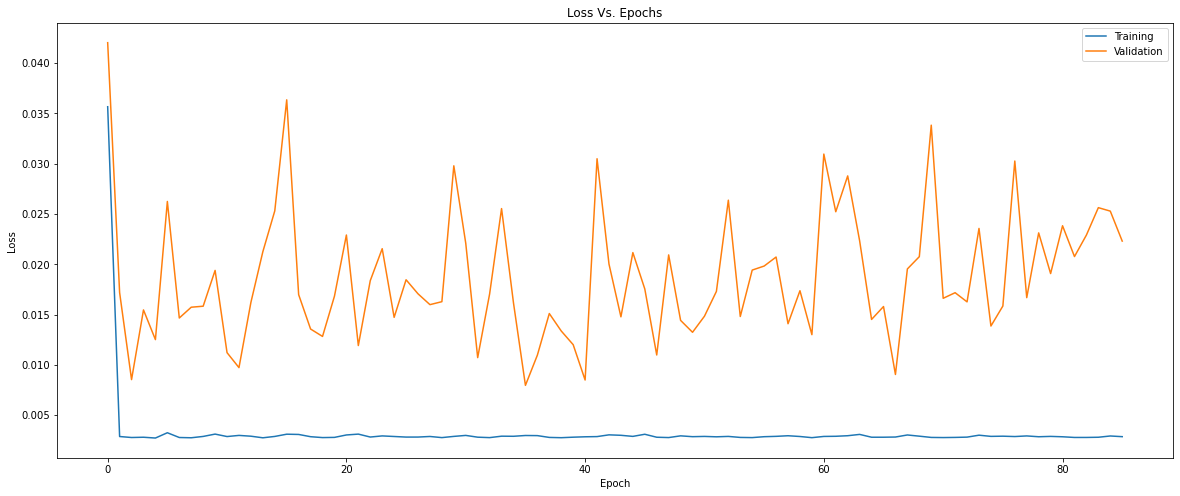

In [114]:
plt.figure(figsize=(20,8));

plt.plot(range(86), history.history['loss'], label='Training');
plt.plot(range(86), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [116]:
lstm_lr_pred = y_scaler.inverse_transform(lstm_best_lr.predict(lstm_X_valid))

lstm_lr_mse = sk_mse(lstm_lr_pred, valid_y)
print(f'Mean Squared Error of Simple Regressor: {lstm_lr_mse}')

Mean Squared Error of Simple Regressor: 2.2212302721702692


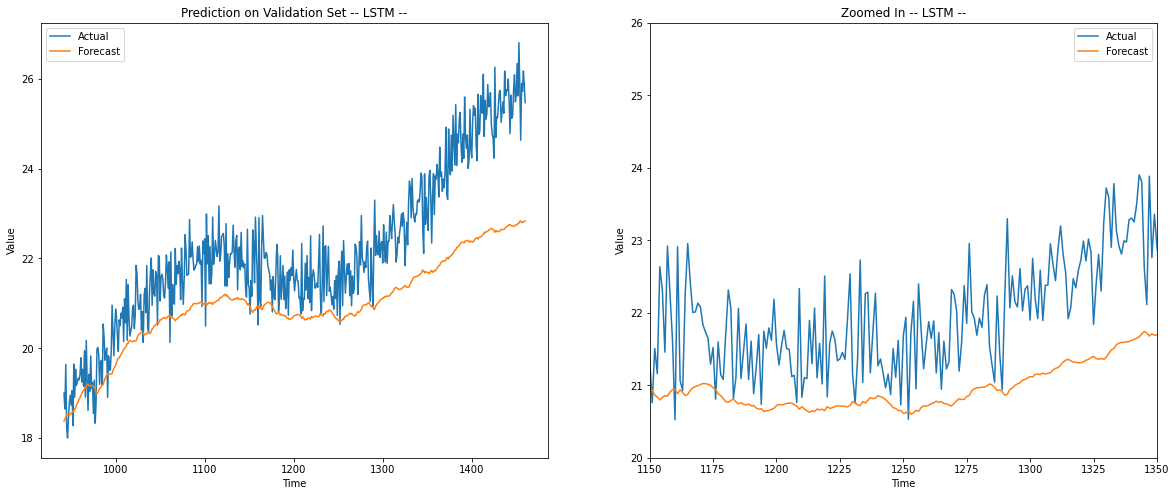

In [117]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- LSTM --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], lstm_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- LSTM --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], lstm_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

## 1D CNN + LSTM 

In [121]:
from keras.layers import Conv1D

cnn_pick_lr = Sequential(
    [
        Conv1D(filters=32, kernel_size=5, padding='causal',
               input_shape=(WINDOW_SIZE,1), activation='relu'),
        LSTM(32, return_sequences=True),
        LSTM(32),
        Dense(1)
    ]
)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 30))

cnn_pick_lr.compile(optimizer=Adam(0.01), loss=mean_squared_error)

history = cnn_pick_lr.fit(lstm_X_train, scaled_y_train,
                          validation_data=(lstm_X_valid, scaled_y_valid),
                          batch_size=16, epochs=100,
                          callbacks=[lr_schedule])

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 3s 4ms/step - loss: 0.3831 - val_loss: 1.8846
Epoch 2/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3783 - val_loss: 1.8642
Epoch 3/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3732 - val_loss: 1.8426
Epoch 4/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3677 - val_loss: 1.8193
Epoch 5/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3619 - val_loss: 1.7944
Epoch 6/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3556 - val_loss: 1.7677
Epoch 7/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3491 - val_loss: 1.7394
Epoch 8/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3420 - val_loss: 1.7094
Epoch 9/100
882/882 [==============================] - 1s 1ms/step - loss: 0.3346 - val_loss: 1.6770
Epoch 10/100
882/882 [=======================

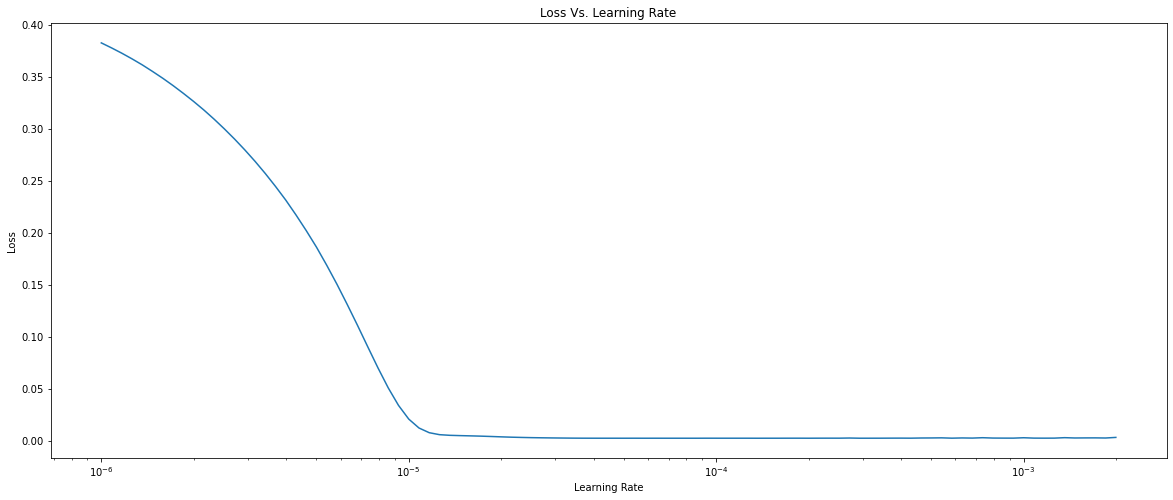

In [122]:
plt.figure(figsize=(20,8));

plt.title('Loss Vs. Learning Rate')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate');
plt.ylabel('Loss');

In [124]:
cnn_best_lr = Sequential(
    [
        Conv1D(filters=32, kernel_size=5, padding='causal',
               input_shape=(WINDOW_SIZE,1), activation='relu'),
        LSTM(32, return_sequences=True),
        LSTM(32),
        Dense(1)
    ]
)

earlyStopping = EarlyStopping(patience=50)

cnn_best_lr.compile(optimizer=Adam(1e-5), loss=mean_squared_error)

history = cnn_best_lr.fit(lstm_X_train, scaled_y_train,
                          validation_data=(lstm_X_valid, scaled_y_valid),
                          batch_size=16, epochs=500,
                          callbacks=[earlyStopping])

Train on 882 samples, validate on 519 samples
Epoch 1/500
882/882 [==============================] - 3s 3ms/step - loss: 0.2395 - val_loss: 1.1481
Epoch 2/500
882/882 [==============================] - 1s 1ms/step - loss: 0.2080 - val_loss: 1.0169
Epoch 3/500
882/882 [==============================] - 1s 1ms/step - loss: 0.1777 - val_loss: 0.8874
Epoch 4/500
882/882 [==============================] - 1s 1ms/step - loss: 0.1480 - val_loss: 0.7578
Epoch 5/500
882/882 [==============================] - 1s 1ms/step - loss: 0.1190 - val_loss: 0.6281
Epoch 6/500
882/882 [==============================] - 1s 1ms/step - loss: 0.0914 - val_loss: 0.5026
Epoch 7/500
882/882 [==============================] - 1s 1ms/step - loss: 0.0664 - val_loss: 0.3850
Epoch 8/500
882/882 [==============================] - 1s 1ms/step - loss: 0.0445 - val_loss: 0.2819
Epoch 9/500
882/882 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.1976
Epoch 10/500
882/882 [=======================

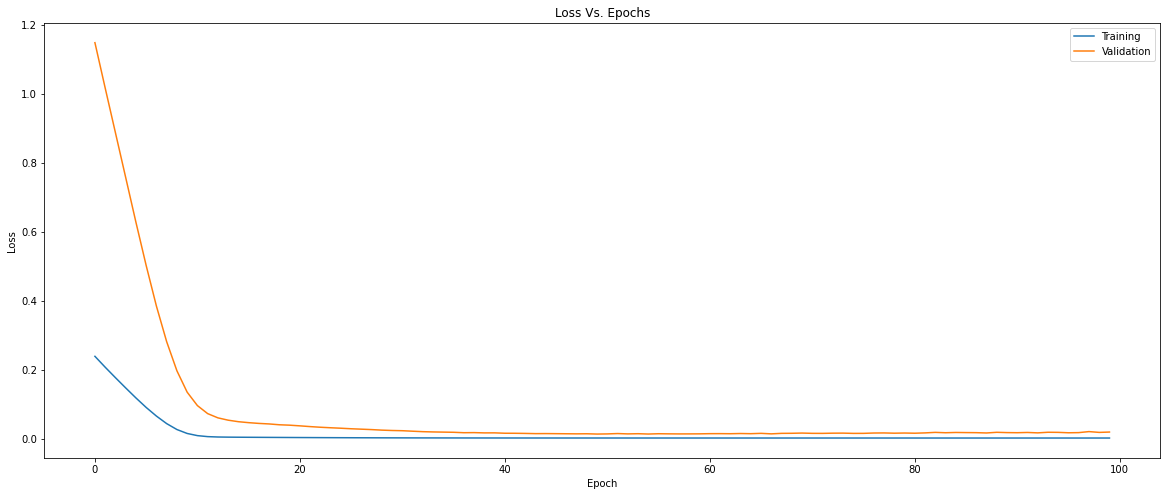

In [125]:
plt.figure(figsize=(20,8));

plt.plot(range(100), history.history['loss'], label='Training');
plt.plot(range(100), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [138]:
cnn_lr_pred = y_scaler.inverse_transform(cnn_best_lr.predict(lstm_X_valid))

cnn_lr_mse = sk_mse(cnn_lr_pred, valid_y)
print(f'Mean Squared Error of 1D CNN Regressor: {cnn_lr_mse}')

Mean Squared Error of 1D CNN Regressor: 2.0036613029210835


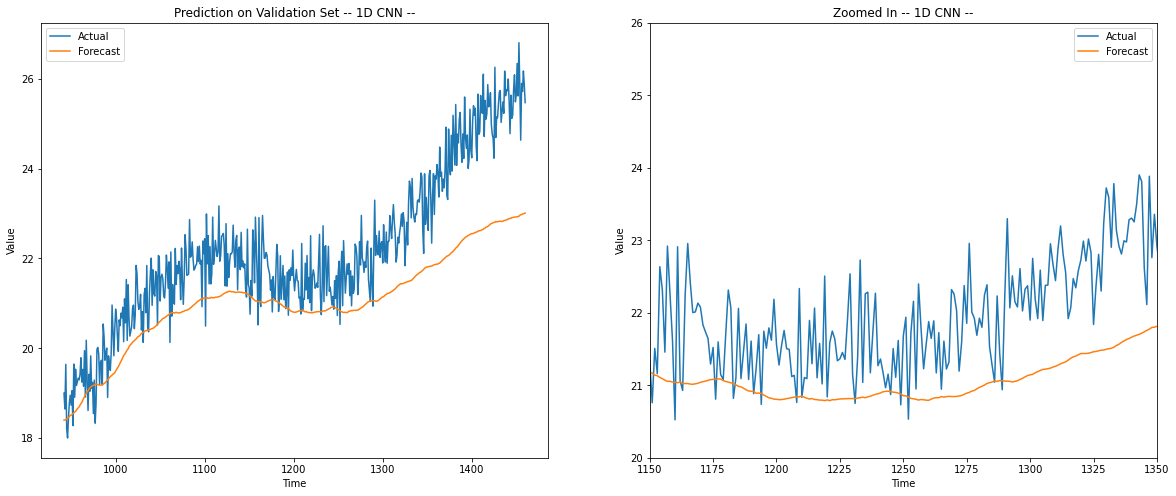

In [142]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- 1D CNN --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- 1D CNN --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

## WaveNet (1D CNN) With CheckPoint

In [194]:
from keras.layers import Flatten

waveNet_pick_lr = Sequential(
    [
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=1, activation='relu',
               input_shape=(WINDOW_SIZE,1), ),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=2, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=4, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=8, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=16, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=32, activation='relu'),
        
        Conv1D(filters=1, kernel_size=1),
        Flatten(),
        Dense(1)

    ]
)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 30))

waveNet_pick_lr.compile(optimizer=Adam(0.01), loss=mean_squared_error)

history = waveNet_pick_lr.fit(lstm_X_train, scaled_y_train,
                              validation_data=(lstm_X_valid, scaled_y_valid),
                              batch_size=16, epochs=100,
                              callbacks=[lr_schedule])

Train on 882 samples, validate on 519 samples
Epoch 1/100
882/882 [==============================] - 1s 2ms/step - loss: 0.3210 - val_loss: 1.5883
Epoch 2/100
882/882 [==============================] - 0s 401us/step - loss: 0.3201 - val_loss: 1.5848
Epoch 3/100
882/882 [==============================] - 0s 377us/step - loss: 0.3191 - val_loss: 1.5810
Epoch 4/100
882/882 [==============================] - 0s 372us/step - loss: 0.3180 - val_loss: 1.5769
Epoch 5/100
882/882 [==============================] - 1s 686us/step - loss: 0.3169 - val_loss: 1.5725ETA: 0s - loss: 0.31
Epoch 6/100
882/882 [==============================] - 0s 378us/step - loss: 0.3157 - val_loss: 1.5677
Epoch 7/100
882/882 [==============================] - 0s 378us/step - loss: 0.3144 - val_loss: 1.5624
Epoch 8/100
882/882 [==============================] - 0s 397us/step - loss: 0.3129 - val_loss: 1.5567
Epoch 9/100
882/882 [==============================] - 0s 355us/step - loss: 0.3114 - val_loss: 1.5502
Epoch 10/

882/882 [==============================] - 0s 332us/step - loss: 0.0030 - val_loss: 0.0186
Epoch 79/100
882/882 [==============================] - 0s 340us/step - loss: 0.0031 - val_loss: 0.0105
Epoch 80/100
882/882 [==============================] - 0s 341us/step - loss: 0.0031 - val_loss: 0.0095
Epoch 81/100
882/882 [==============================] - 0s 355us/step - loss: 0.0031 - val_loss: 0.0128
Epoch 82/100
882/882 [==============================] - 0s 342us/step - loss: 0.0029 - val_loss: 0.0168
Epoch 83/100
882/882 [==============================] - 0s 341us/step - loss: 0.0029 - val_loss: 0.0091
Epoch 84/100
882/882 [==============================] - 0s 340us/step - loss: 0.0029 - val_loss: 0.0087
Epoch 85/100
882/882 [==============================] - 0s 340us/step - loss: 0.0031 - val_loss: 0.0190
Epoch 86/100
882/882 [==============================] - 0s 341us/step - loss: 0.0030 - val_loss: 0.0364
Epoch 87/100
882/882 [==============================] - 0s 356us/step - loss:

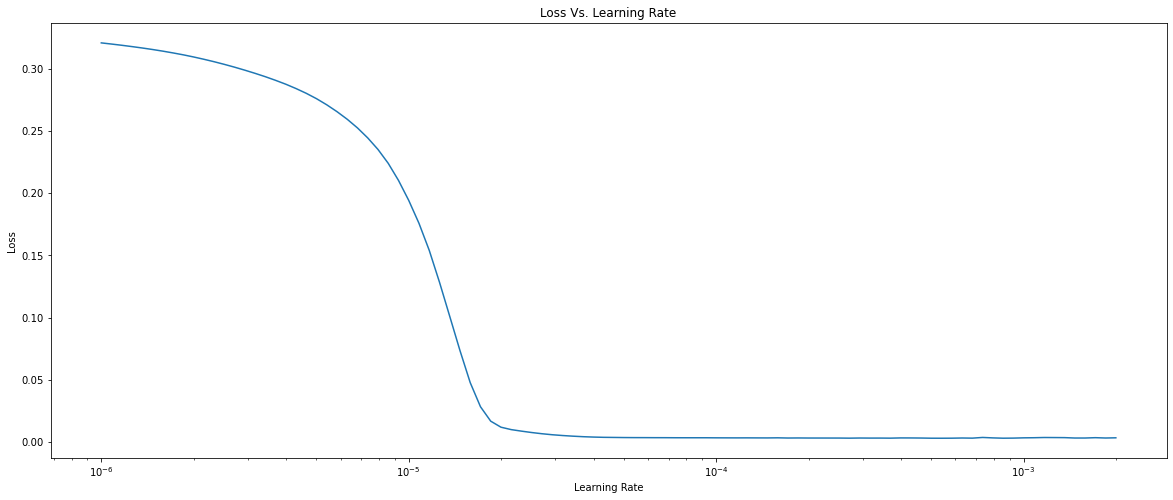

In [195]:
plt.figure(figsize=(20,8));

plt.title('Loss Vs. Learning Rate')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate');
plt.ylabel('Loss');

In [196]:
from keras.callbacks import ModelCheckpoint

waveNet_best_lr = Sequential(
    [
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=1, activation='relu',
               input_shape=(WINDOW_SIZE,1), ),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=2, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=4, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=8, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=16, activation='relu'),
        Conv1D(filters=32, kernel_size=2, padding='causal',
               dilation_rate=32, activation='relu'),
        
        Conv1D(filters=1, kernel_size=1),
        Flatten(),
        Dense(1)

    ]
)

earlyStopping = EarlyStopping(patience=50)
checkPoint = ModelCheckpoint('conv1D.h5',save_best_only=True)

waveNet_best_lr.compile(optimizer=Adam(1e-5), loss=mean_squared_error)

history = waveNet_best_lr.fit(lstm_X_train, scaled_y_train,
                              validation_data=(lstm_X_valid, scaled_y_valid),
                              batch_size=16, epochs=500,
                              callbacks=[earlyStopping, checkPoint],
                             )

Train on 882 samples, validate on 519 samples
Epoch 1/500
882/882 [==============================] - 2s 2ms/step - loss: 0.3113 - val_loss: 1.5057
Epoch 2/500
882/882 [==============================] - 0s 425us/step - loss: 0.2827 - val_loss: 1.4026
Epoch 3/500
882/882 [==============================] - 0s 422us/step - loss: 0.2545 - val_loss: 1.2955
Epoch 4/500
882/882 [==============================] - 0s 422us/step - loss: 0.2279 - val_loss: 1.1957
Epoch 5/500
882/882 [==============================] - 0s 451us/step - loss: 0.2028 - val_loss: 1.0961
Epoch 6/500
882/882 [==============================] - 0s 452us/step - loss: 0.1779 - val_loss: 0.9918
Epoch 7/500
882/882 [==============================] - 0s 403us/step - loss: 0.1543 - val_loss: 0.8895
Epoch 8/500
882/882 [==============================] - 0s 407us/step - loss: 0.1322 - val_loss: 0.7887
Epoch 9/500
882/882 [==============================] - 0s 397us/step - loss: 0.1114 - val_loss: 0.6920
Epoch 10/500
882/882 [=======

882/882 [==============================] - 0s 345us/step - loss: 0.0029 - val_loss: 0.0136
Epoch 80/500
882/882 [==============================] - 0s 341us/step - loss: 0.0029 - val_loss: 0.0135
Epoch 81/500
882/882 [==============================] - 0s 343us/step - loss: 0.0029 - val_loss: 0.0135
Epoch 82/500
882/882 [==============================] - 0s 342us/step - loss: 0.0029 - val_loss: 0.0146
Epoch 83/500
882/882 [==============================] - 0s 346us/step - loss: 0.0029 - val_loss: 0.0140
Epoch 84/500
882/882 [==============================] - 0s 343us/step - loss: 0.0029 - val_loss: 0.0130
Epoch 85/500
882/882 [==============================] - 0s 335us/step - loss: 0.0029 - val_loss: 0.0133
Epoch 86/500
882/882 [==============================] - 0s 352us/step - loss: 0.0029 - val_loss: 0.0143
Epoch 87/500
882/882 [==============================] - 0s 340us/step - loss: 0.0029 - val_loss: 0.0131
Epoch 88/500
882/882 [==============================] - 0s 342us/step - loss:

882/882 [==============================] - 0s 351us/step - loss: 0.0028 - val_loss: 0.0115
Epoch 158/500
882/882 [==============================] - ETA: 0s - loss: 0.002 - 0s 409us/step - loss: 0.0028 - val_loss: 0.0122
Epoch 159/500
882/882 [==============================] - 0s 393us/step - loss: 0.0028 - val_loss: 0.0122
Epoch 160/500
882/882 [==============================] - 0s 395us/step - loss: 0.0028 - val_loss: 0.0117
Epoch 161/500
882/882 [==============================] - 0s 417us/step - loss: 0.0028 - val_loss: 0.0120
Epoch 162/500
882/882 [==============================] - 0s 360us/step - loss: 0.0028 - val_loss: 0.0119
Epoch 163/500
882/882 [==============================] - 0s 344us/step - loss: 0.0028 - val_loss: 0.0119
Epoch 164/500
882/882 [==============================] - 0s 349us/step - loss: 0.0028 - val_loss: 0.0111
Epoch 165/500
882/882 [==============================] - 0s 361us/step - loss: 0.0028 - val_loss: 0.0118
Epoch 166/500
882/882 [======================

882/882 [==============================] - 0s 345us/step - loss: 0.0028 - val_loss: 0.0116
Epoch 235/500
882/882 [==============================] - 0s 403us/step - loss: 0.0028 - val_loss: 0.0124
Epoch 236/500
882/882 [==============================] - 0s 416us/step - loss: 0.0028 - val_loss: 0.0117
Epoch 237/500
882/882 [==============================] - 0s 349us/step - loss: 0.0028 - val_loss: 0.0115
Epoch 238/500
882/882 [==============================] - 0s 343us/step - loss: 0.0028 - val_loss: 0.0123
Epoch 239/500
882/882 [==============================] - 0s 357us/step - loss: 0.0028 - val_loss: 0.0111
Epoch 240/500
882/882 [==============================] - 0s 371us/step - loss: 0.0028 - val_loss: 0.0132
Epoch 241/500
882/882 [==============================] - 0s 353us/step - loss: 0.0028 - val_loss: 0.0119


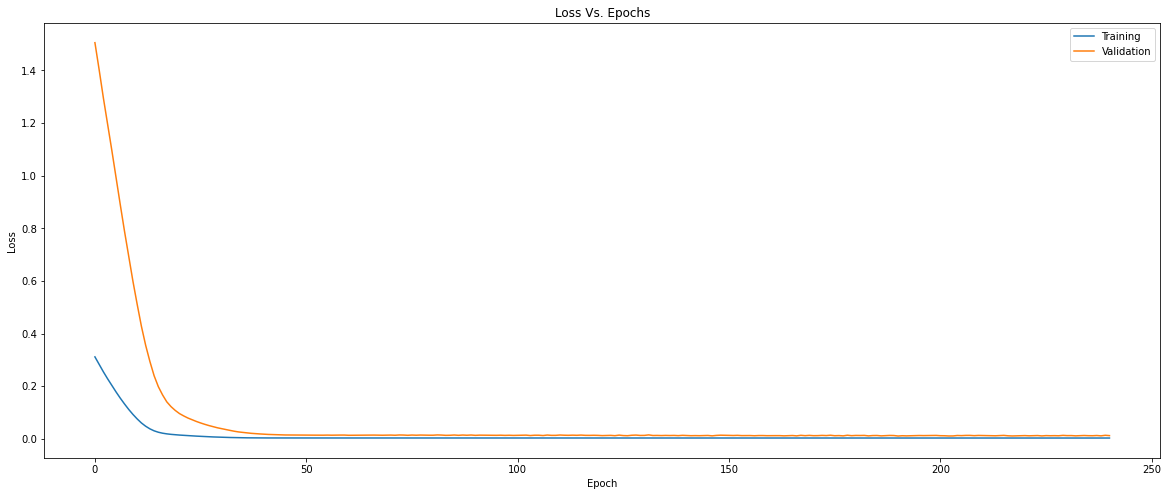

In [197]:
plt.figure(figsize=(20,8));

plt.plot(range(241), history.history['loss'], label='Training');
plt.plot(range(241), history.history['val_loss'], label='Validation');
plt.title('Loss Vs. Epochs')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

In [198]:
waveNet_lr_pred = y_scaler.inverse_transform(waveNet_best_lr.predict(lstm_X_valid))

waveNet_lr_mse = sk_mse(waveNet_lr_pred, valid_y)
print(f'Mean Squared Error of WaveNet Regressor: {waveNet_lr_mse}')

Mean Squared Error of WaveNet Regressor: 1.1883108697783606


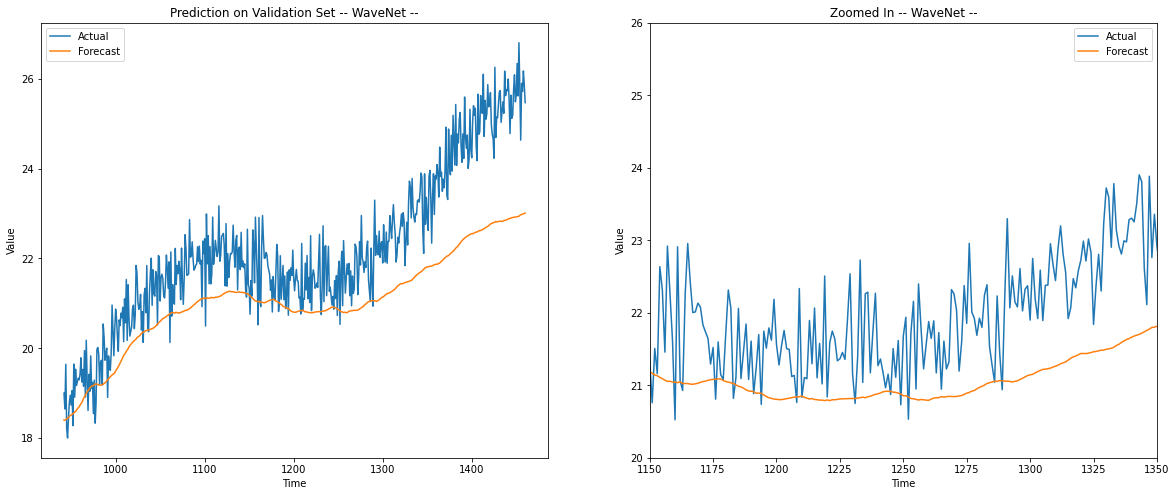

In [199]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- WaveNet --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- WaveNet --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();

### Best WaveNet Model CheckPoint

In [200]:
best_waveNet = keras.models.load_model('conv1D.h5')

waveNet_pred = y_scaler.inverse_transform(best_waveNet.predict(lstm_X_valid))

waveNet_mse = sk_mse(waveNet_pred, valid_y)
print(f'Mean Squared Error of best WaveNet Regressor: {waveNet_mse}')

Mean Squared Error of best WaveNet Regressor: 1.0421170883071245


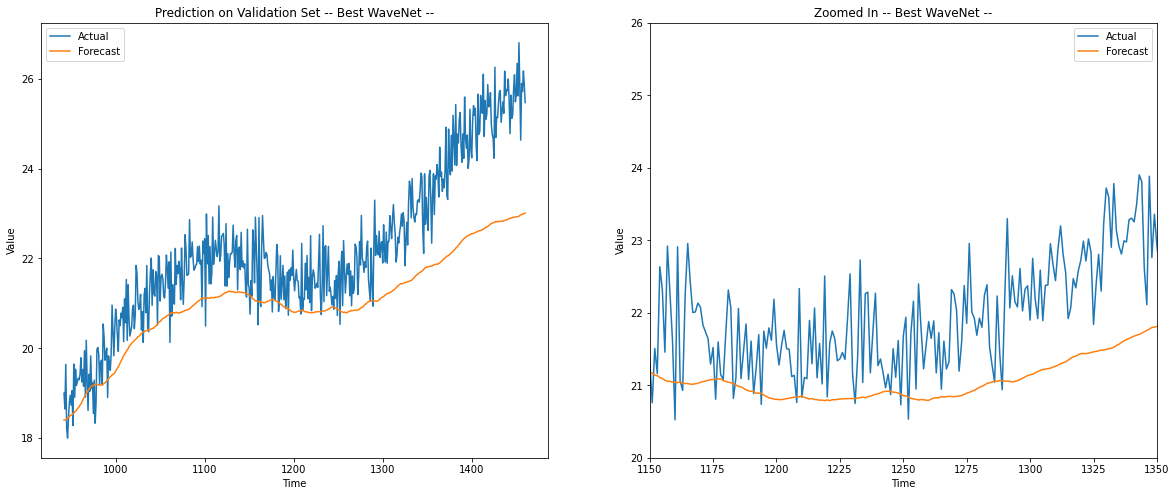

In [201]:
plt.figure(figsize=(20,8));

plt.subplot(1,2,1)
plt.title('Prediction on Validation Set -- Best WaveNet --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.legend();


plt.subplot(1,2,2)
plt.title('Zoomed In -- Best WaveNet --')
plt.plot(valid_time[WINDOW_SIZE:], valid_y, label='Actual');
plt.plot(valid_time[WINDOW_SIZE:], cnn_lr_pred, label='Forecast');
plt.xlabel('Time');
plt.ylabel('Value');
plt.axis([1150, 1350, 20, 26])
plt.legend();